# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def sizeMap(inputSize):
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    C5 = (S4-50)+1
    S6 = int(C5/2)
    return C1, S2, C3, S4, C5, S6

def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list

## read  data

In [3]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_1 = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_2 = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [4]:
# read sy19 with noise   
sy19_noise_feature = []
for file in glob.glob('sy19*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature = np.concatenate((sy19_noise_feature, file_feature), axis=0)

reading: sy19-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.4.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.5.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.6.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.7.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.8.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.9.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-pixels-3800-7500-redshifte

In [38]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
sy19_feature = np.concatenate((sy19_feature_1, sy19_feature_2, sy19_noise_feature), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature = torch.Tensor(sy19_feature).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

In [39]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label = torch.ones(sy19_feature.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

# create indices
sy19_indice = torch.linspace(0,len(sy19_feature)-1,len(sy19_feature)).int()
sy20_indice = torch.linspace(0,len(sy20_feature)-1,len(sy20_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
sy19_dataset = TensorDataset(sy19_indice,sy19_feature,sy19_label)
sy20_dataset = TensorDataset(sy20_indice[:len(sy19_feature)],sy20_feature[:len(sy19_feature)],sy20_label[:len(sy19_feature)])

In [40]:
# split to train and test datasets
train_ratio = 0.75
train_size = int(train_ratio * len(sy19_dataset))
test_size = len(sy19_dataset) - train_size

sy19_train_dataset, sy19_test_dataset = random_split(sy19_dataset, [train_size, test_size])
sy20_train_dataset, sy20_test_dataset = random_split(sy20_dataset, [train_size, test_size])

# merge the test dataset
dataset = ConcatDataset((sy19_train_dataset,sy20_train_dataset))

## read test data

In [8]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
#sy19_test_feature = genfromtxt('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
#sy20_test_feature = genfromtxt('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
#
#sy19_test_feature = torch.Tensor(sy19_test_feature).view(-1,7500-3800+1)
#sy20_test_feature = torch.Tensor(sy20_test_feature).view(-1,7500-3800+1)

In [9]:
# classify 1.9 as 1, and 2 as 0. 
#sy19_test_label = torch.ones(sy19_test_feature.size(0),dtype=torch.long)
#sy20_test_label = torch.zeros(sy20_test_feature.size(0),dtype=torch.long)

# create indices
#sy19_test_indice = torch.linspace(0,len(sy19_test_feature)-1,len(sy19_test_feature)).int()
#sy20_test_indice = torch.linspace(0,len(sy20_test_feature)-1,len(sy20_test_feature)).int()

In [10]:
#sy19_test_dataset = TensorDataset(sy19_test_indice,sy19_test_feature,sy19_test_label)
#sy20_test_dataset = TensorDataset(sy20_test_indice,sy20_test_feature,sy20_test_label)

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F9 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  D8 | Dropout (0.5) | - | - | - | - | - | - | - |
|  C7 | Convolution | 1000 | 419 | 0 | 1 | 1 | ReLU |  |
|  S6 | Avg Pooling | 256 | 2 | 0 | 2 | 419 | - |  |
|  C5 | Convolution | 256 | 50 | 0 | 1 | 839 | ReLU |  |
|  S4 | Avg Pooling | 128 | 2 | 0 | 2 | 888 | - |  |
|  C3 | Convolution | 128 | 50 | 0 | 1 | 1777 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [11]:
sizeMap(3701)

(3652, 1826, 1777, 888, 839, 419)

In [12]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 256, 50)
        self.S6 = nn.AvgPool1d(2, stride=2)
        self.C7 = nn.Conv1d(256, 1000, 419)
        self.D8 = nn.Dropout(0.5)
        self.F9 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.S4(x)
        x = F.relu(self.C5(x),inplace=True)
        x = self.S6(x)
        x = F.relu(self.C7(x),inplace=True)
        x = self.D8(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F9(x),inplace=True)
        x = self.Out(x)
        return x

In [30]:
net = simpleCNN()
print(net)

simpleCNN(
  (C1): Conv1d(1, 64, kernel_size=(50,), stride=(1,))
  (S2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C3): Conv1d(64, 128, kernel_size=(50,), stride=(1,))
  (S4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C5): Conv1d(128, 256, kernel_size=(50,), stride=(1,))
  (S6): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C7): Conv1d(256, 1000, kernel_size=(419,), stride=(1,))
  (D8): Dropout(p=0.5)
  (F9): Linear(in_features=1000, out_features=100, bias=True)
  (Out): Linear(in_features=100, out_features=2, bias=True)
)


In [31]:
## Test
x = torch.randn(5,1,3701)
net(x)

tensor([[0.0151, 0.0495],
        [0.0290, 0.0602],
        [0.0141, 0.0563],
        [0.0156, 0.0416],
        [0.0148, 0.0492]], grad_fn=<AddmmBackward>)

### Check GPU availabel

In [32]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(5)
    device = torch.device('cuda:5')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### define optimizer, loss function and accuracy 

In [62]:
learning_rate = 0.00001

loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [34]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,3701)
        # 如果 device 是 GPU，将数据复制到 GPU 上。
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

In [42]:
num_epochs = 100

batch_size = 50
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [36]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [63]:
for epoch in range(num_epochs):
    #learning_rate = 0.968*learning_rate
    #loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,3701)
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        sy19_test_iter = DataLoader(sy19_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        sy19_test_acc = evaluate_accuracy(sy19_test_iter, net, device)
        sy20_test_iter = DataLoader(sy20_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        sy20_test_acc = evaluate_accuracy(sy20_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, sy19 test acc  %.4f, sy20 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    sy19_test_acc, sy20_test_acc, time.time() - start))
        sy19_test_acc_list.append(sy19_test_acc)
        sy20_test_acc_list.append(sy20_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))
    

epoch 1, loss 0.000210, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 162.4 sec
epoch 2, loss 0.000645, train acc 0.999837, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 3, loss 0.000307, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 4, loss 0.000289, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.2 sec
epoch 5, loss 0.000289, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 6, loss 0.000329, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 7, loss 0.000203, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9853, time 163.2 sec
epoch 8, loss 0.000188, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 9, loss 0.000218, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 10, loss 0.000162, train acc 1.000000, sy19 test 

epoch 79, loss 0.000176, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 80, loss 0.000305, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9853, time 163.1 sec
epoch 81, loss 0.000245, train acc 0.999919, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 82, loss 0.000523, train acc 0.999837, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 83, loss 0.000199, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 84, loss 0.000230, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 85, loss 0.000374, train acc 0.999837, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.0 sec
epoch 86, loss 0.000186, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 162.9 sec
epoch 87, loss 0.000172, train acc 1.000000, sy19 test acc  0.9951, sy20 test acc  0.9854, time 163.1 sec
epoch 88, loss 0.000299, train acc 0.999919, s

In [66]:
## save results

acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'sy19_test_acc': sy19_test_acc_list, 'sy20_test_acc': sy20_test_acc_list})
acc_lists_filename = 'acc-list-cuda5-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)

torch.save(net.state_dict(), './cuda5.pt')

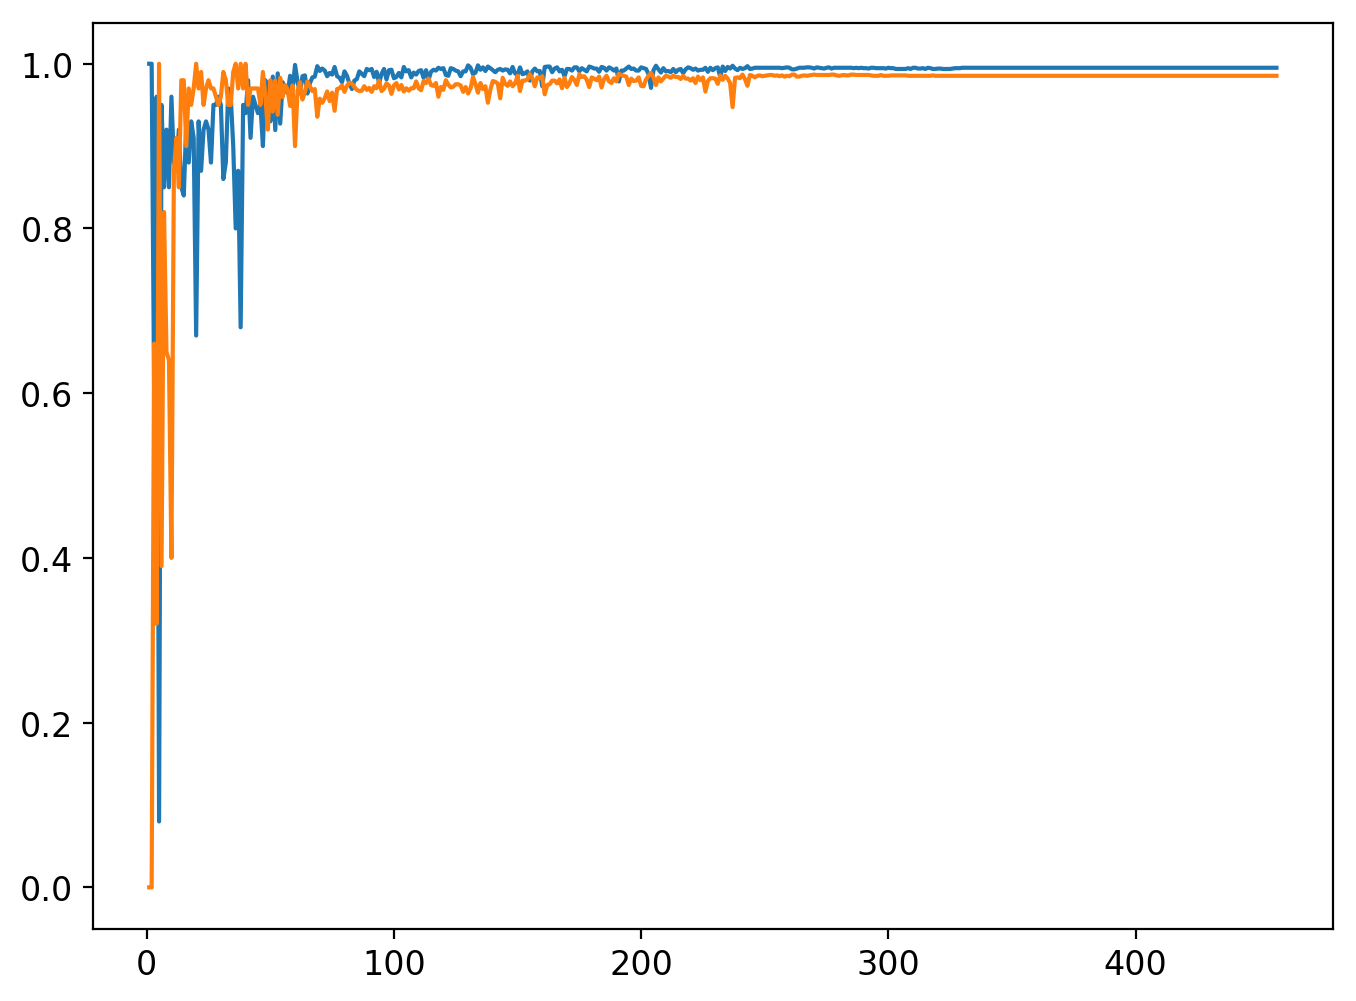

In [64]:
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, sy19_test_acc_list)
plt.plot(epoches, sy20_test_acc_list)

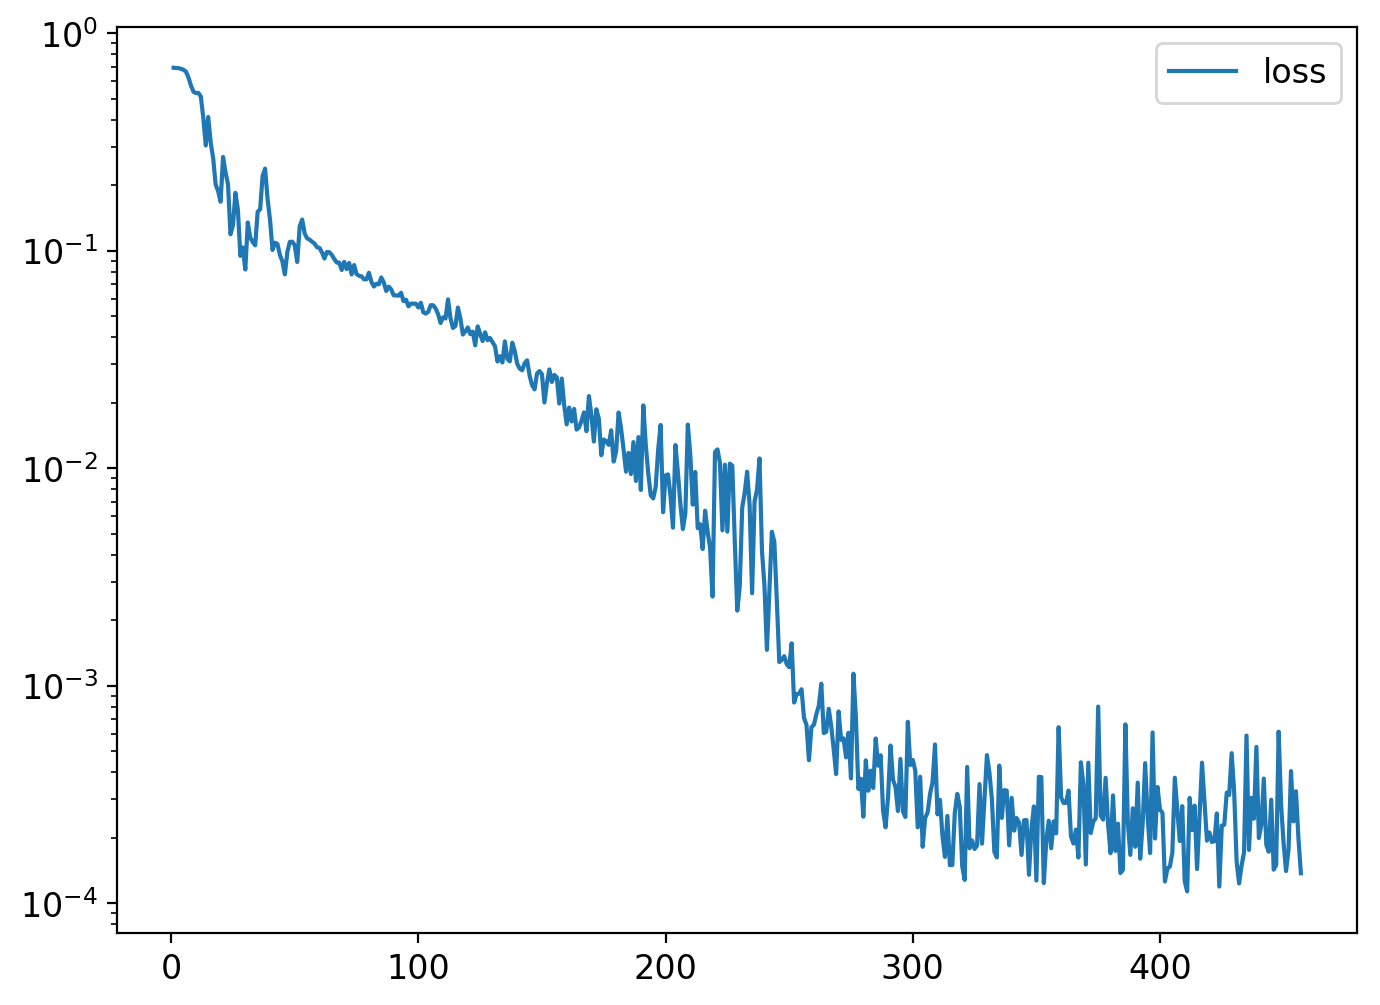

In [65]:
plt.semilogy(epoches, loss_list,label='loss')
plt.legend()

In [ ]:
0.968**100